# Stage-1 : Data Exploration and Cleaning

### Importing Required Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as ss
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')


### Import Training and Testing Data "df_train" and "df_test"

In [2]:
df_train = pd.read_csv('/kaggle/input/ml-project-data/train.csv')
df_test = pd.read_csv('/kaggle/input/ml-project-data/test.csv')
print("Training Data Shape:", df_train.shape)
print("\nTraining Data First 5 Rows:")
print(df_train.head())
print("Training Data Shape:", df_test.shape)
print("\nTesting Data First 5 Rows:")
print(df_test.head())

Training Data Shape: (15533, 18)

Training Data First 5 Rows:
   id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       

### Checking null values by counting missing numbers

In [3]:
print("Training set missing values:")
print(df_train.isnull().sum())
print("\nTest set missing values:")
print(df_test.isnull().sum())

Training set missing values:
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
WeightCategory                    0
dtype: int64

Test set missing values:
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                            

### Checking duplicate rows it can bias model training so remove if it exists

In [4]:
print("Train duplicates:", df_train.duplicated().sum())
print("Test duplicates:", df_test.duplicated().sum())

Train duplicates: 0
Test duplicates: 0


### Inspecting unique values in categorical columns so that we can understand where to apply one-hot encoding 

In [5]:
for col in ['Gender', 'MTRANS', 'FAVC', 'FCVC', 'CAEC', 'SMOKE', 'SCC', 'CALC']:
    print(f"{col} unique values:", df_train[col].unique())

Gender unique values: ['Male' 'Female']
MTRANS unique values: ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
FAVC unique values: ['yes' 'no']
FCVC unique values: [2.         1.880534   3.         2.679664   2.919751   1.99124
 1.397468   2.636719   1.         1.392665   2.203962   2.971588
 2.668949   1.98989905 2.417635   2.219186   2.919526   2.263245
 2.649406   1.754401   2.303656   2.020785   2.068834   2.689929
 2.979383   2.225731   2.843456   2.312528   2.962415   2.945967
 2.108638   1.826885   2.200588   2.598051   2.984425   1.387489
 2.76533    2.941627   2.490776   2.801514   2.336044   1.270448
 2.9673     2.325623   2.722161   2.680375   2.938801   2.431346
 1.994679   2.393837   1.428289   2.341999   2.967853   1.899116
 1.906194   2.859097   2.997951   2.499388   1.4925     2.239634
 2.587789   2.795086   2.805512   2.048962   2.319776   2.823179
 1.188089   2.671238   1.882235   2.61939    2.191429   2.995599
 2.594653   1.369529   2.457548   2.73

### Create Copy of dataset and drop columns

In [6]:
df_train_processed = df_train.copy()
df_test_processed = df_test.copy()

y_train = df_train_processed['WeightCategory']
train_ids = df_train_processed['id']
test_ids = df_test_processed['id']

df_train_processed = df_train_processed.drop(['id', 'WeightCategory'], axis=1)
df_test_processed = df_test_processed.drop(['id'], axis=1)

print("Features after dropping ID and target:")
print(df_train_processed.columns.tolist())


Features after dropping ID and target:
['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']


### Lable Encoding 

In [7]:
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")


label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on training data only, then transform both train and test
    df_train_processed[col] = le.fit_transform(df_train_processed[col].astype(str))
    df_test_processed[col] = le.transform(df_test_processed[col].astype(str))
    label_encoders[col] = le

label_encoder_target = LabelEncoder()
y_train_encoded = label_encoder_target.fit_transform(y_train)

print(f"\nTarget classes: {label_encoder_target.classes_}")
print(f"Encoded targets: {np.unique(y_train_encoded)}")

print("\nMissing values after preprocessing:")
print("Train:", df_train_processed.isnull().sum().sum())
print("Test:", df_test_processed.isnull().sum().sum())

print(f"\nFinal data shapes:")
print(f"Train features: {df_train_processed.shape}")
print(f"Test features: {df_test_processed.shape}")
print(f"Train target: {y_train_encoded.shape}")


Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Numerical columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

Target classes: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']
Encoded targets: [0 1 2 3 4 5 6]

Missing values after preprocessing:
Train: 0
Test: 0

Final data shapes:
Train features: (15533, 16)
Test features: (5225, 16)
Train target: (15533,)


# Stage 2: Perform Exploratory Data Analysis (EDA)

### Distribution of Target Variable
It helps to analyze:
- Whether we have a balanced dataset or imbalanced classes
- Which weight categories are most/least common
- If we need to consider class imbalance in our modeling approach

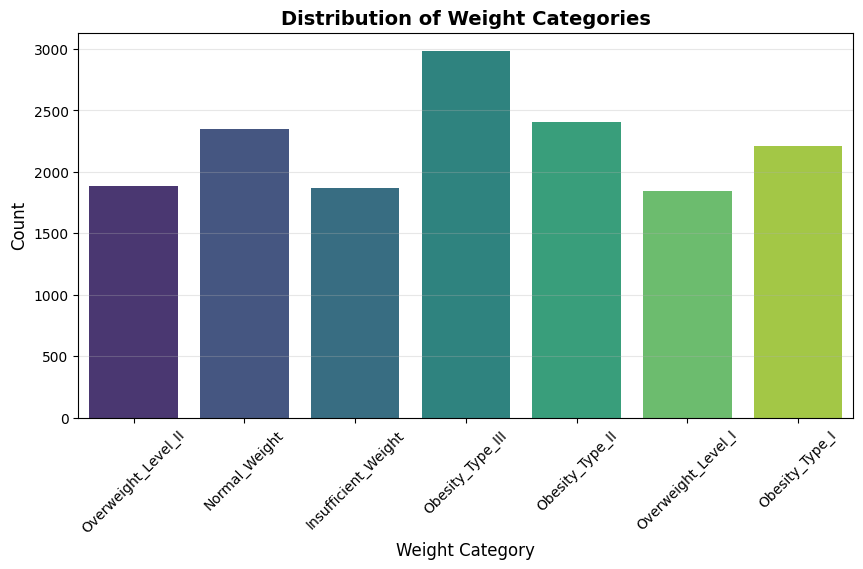

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_train,x='WeightCategory',palette='viridis')
plt.title('Distribution of Weight Categories', fontsize=14, fontweight='bold')
plt.xlabel('Weight Category',fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

### Age distribution by gender
- Gender distribution across different age groups
- whether there are sigmificant age difference between genders
- Presence of any outliers

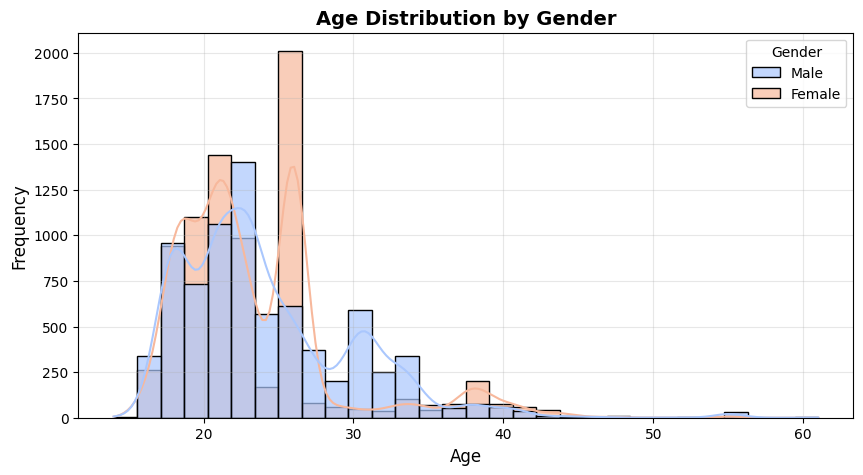

         count       mean     std   min       25%   50%        75%        max
Gender                                                                       
Female  7750.0  23.474115  5.5049  16.0  19.73093  22.0  26.000000  55.022494
Male    7783.0  24.157050  5.7968  14.0  20.00000  23.0  26.978822  61.000000


In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_train, x='Age', hue='Gender', kde=True, palette='coolwarm', alpha=0.7, bins=30)
plt.grid(True)
plt.title('Age Distribution by Gender', fontsize=14, fontweight='bold')
plt.xlabel('Age',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.grid(alpha=0.3)
plt.show()
print(df_train.groupby('Gender')['Age'].describe())

### Correlation between Height vs Weight 
- Relationship between height and weight
- clear boundaries between categories
- correlation between both


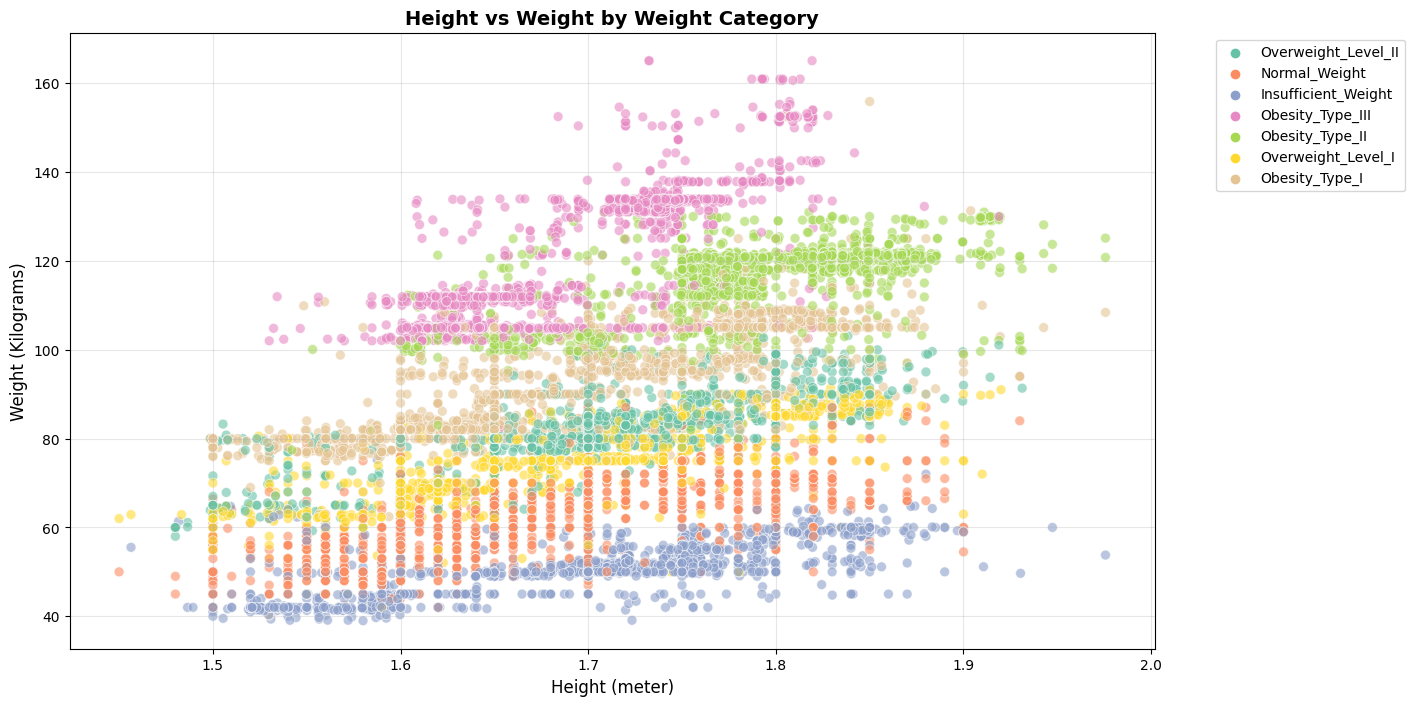

In [10]:
plt.figure(figsize=(14,8))
scatter = sns.scatterplot(data=df_train, x='Height', y='Weight', hue='WeightCategory', palette='Set2', alpha=0.6, s=50)
plt.title('Height vs Weight by Weight Category', fontsize=14, fontweight='bold')
plt.xlabel('Height (meter)', fontsize=12)
plt.ylabel('Weight (Kilograms)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()

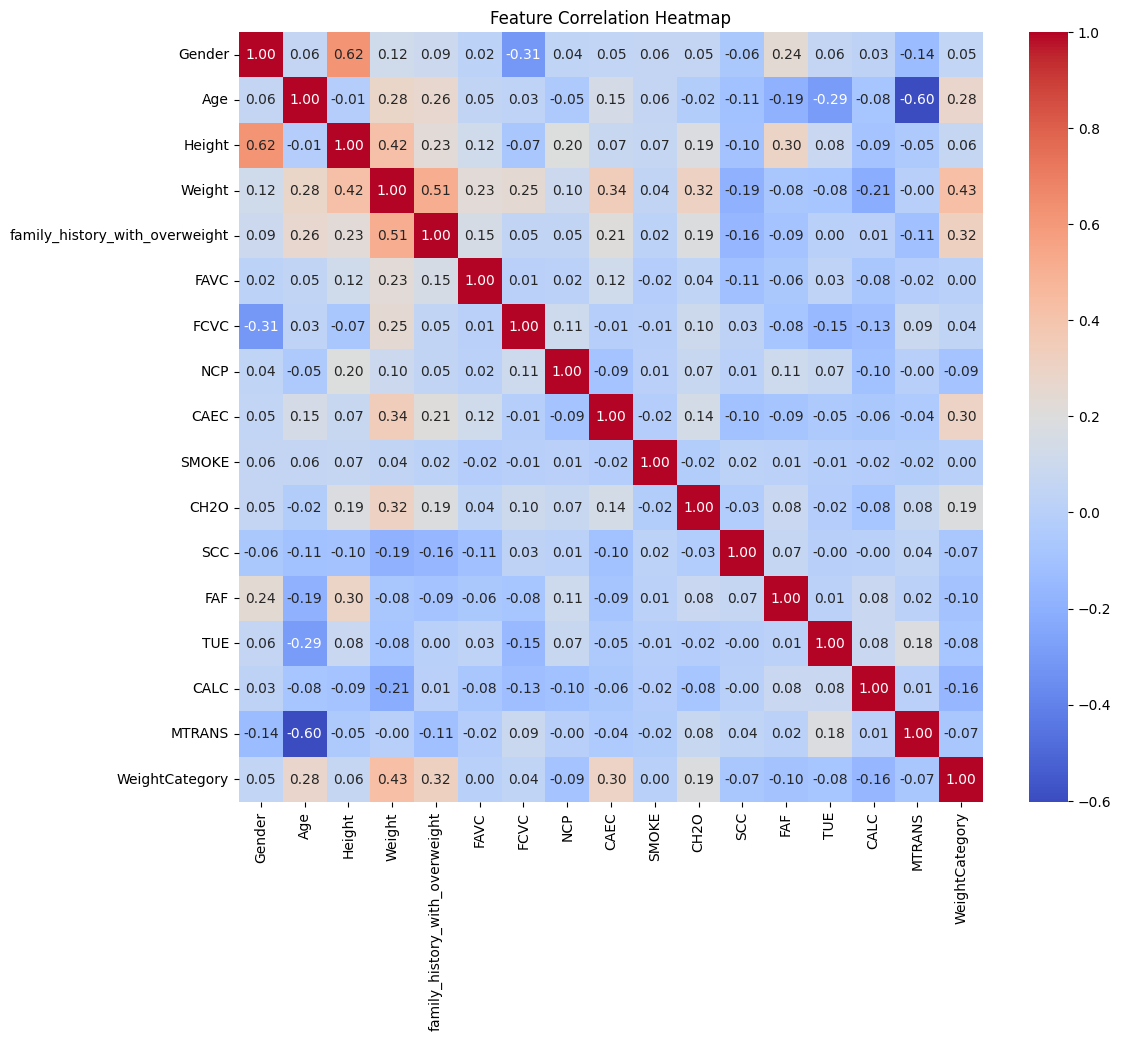

In [11]:
df_corr = df_train_processed.copy()
df_corr['WeightCategory'] = y_train_encoded  
corr_matrix = df_corr.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

### BMI Analysis
- How well BMI correlates with weights
- overlap between categories in terms of BMI ranges
- distribution patterns across different weight classes

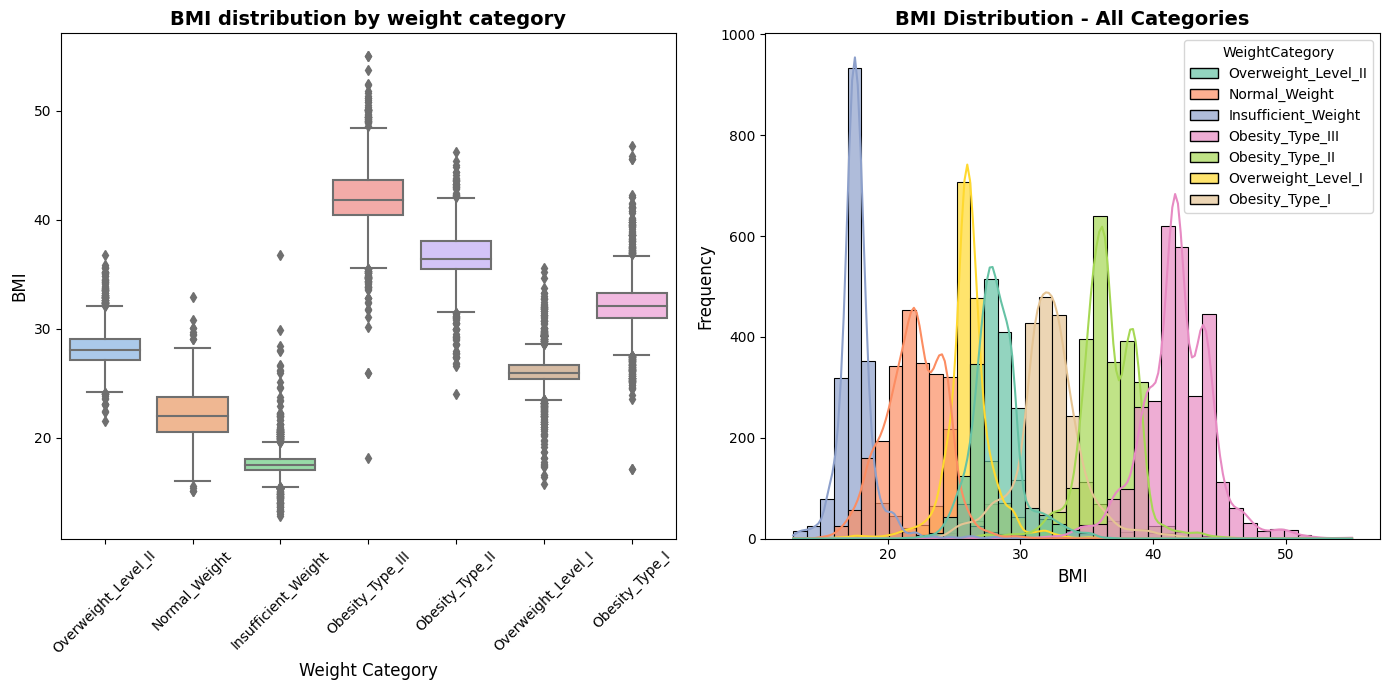

BMI statistics by weight category:
                      count       mean       std        min        25%  \
WeightCategory                                                           
Insufficient_Weight  1870.0  17.620807  1.436097  12.868541  17.037340   
Normal_Weight        2345.0  22.022789  2.199240  15.094795  20.569330   
Obesity_Type_I       2207.0  32.140990  2.563158  17.099278  31.020408   
Obesity_Type_II      2403.0  36.571814  2.114441  24.048460  35.445393   
Obesity_Type_III     2983.0  41.817001  2.690302  18.178670  40.416283   
Overweight_Level_I   1844.0  26.091838  1.800208  15.761880  25.390625   
Overweight_Level_II  1881.0  28.203188  1.797373  21.513859  27.099251   

                           50%        75%        max  
WeightCategory                                        
Insufficient_Weight  17.532467  18.062038  36.778115  
Normal_Weight        22.038567  23.711845  32.882414  
Obesity_Type_I       32.079969  33.320518  46.805188  
Obesity_Type_II      36

In [12]:
df_train['BMI']=df_train['Weight']/(df_train['Height']**2)
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
sns.boxplot(data=df_train,x='WeightCategory',y='BMI',palette='pastel')
plt.title('BMI distribution by weight category',fontsize=14,fontweight='bold')
plt.xlabel('Weight Category',fontsize=12)
plt.ylabel('BMI',fontsize=12)
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.histplot(data=df_train, x='BMI', hue='WeightCategory', kde=True, alpha=0.7, palette='Set2')  
plt.title('BMI Distribution - All Categories', fontsize=14, fontweight='bold')
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()  
plt.show() 
print("BMI statistics by weight category:")  
print(df_train.groupby('WeightCategory')['BMI'].describe())

###  BMI CATEGORY RANGES AND HEALTH CLASSIFICATION

In [13]:
 bmi_ranges = df_train.groupby('WeightCategory')['BMI'].agg(['min', 'max']).round(2)
descriptions = ['Underweight risks','Optimal range','Slight risk','Moderate risk','High diabetes risk','Medical intervention needed','Surgical intervention needed']

print("OBESITY CLASSIFICATION")
for i, category in enumerate(bmi_ranges.index):
    print(f"• {category:<18} ({bmi_ranges.iloc[i,0]}-{bmi_ranges.iloc[i,1]} BMI) - {descriptions[i]}")

OBESITY CLASSIFICATION
• Insufficient_Weight (12.87-36.78 BMI) - Underweight risks
• Normal_Weight      (15.09-32.88 BMI) - Optimal range
• Obesity_Type_I     (17.1-46.81 BMI) - Slight risk
• Obesity_Type_II    (24.05-46.22 BMI) - Moderate risk
• Obesity_Type_III   (18.18-55.0 BMI) - High diabetes risk
• Overweight_Level_I (15.76-35.56 BMI) - Medical intervention needed
• Overweight_Level_II (21.51-36.74 BMI) - Surgical intervention needed


### Family History Impact
- How family history influences weight categories
- Whether genetic factors play a significant role
- Potential risk factors for certain weight categories
  

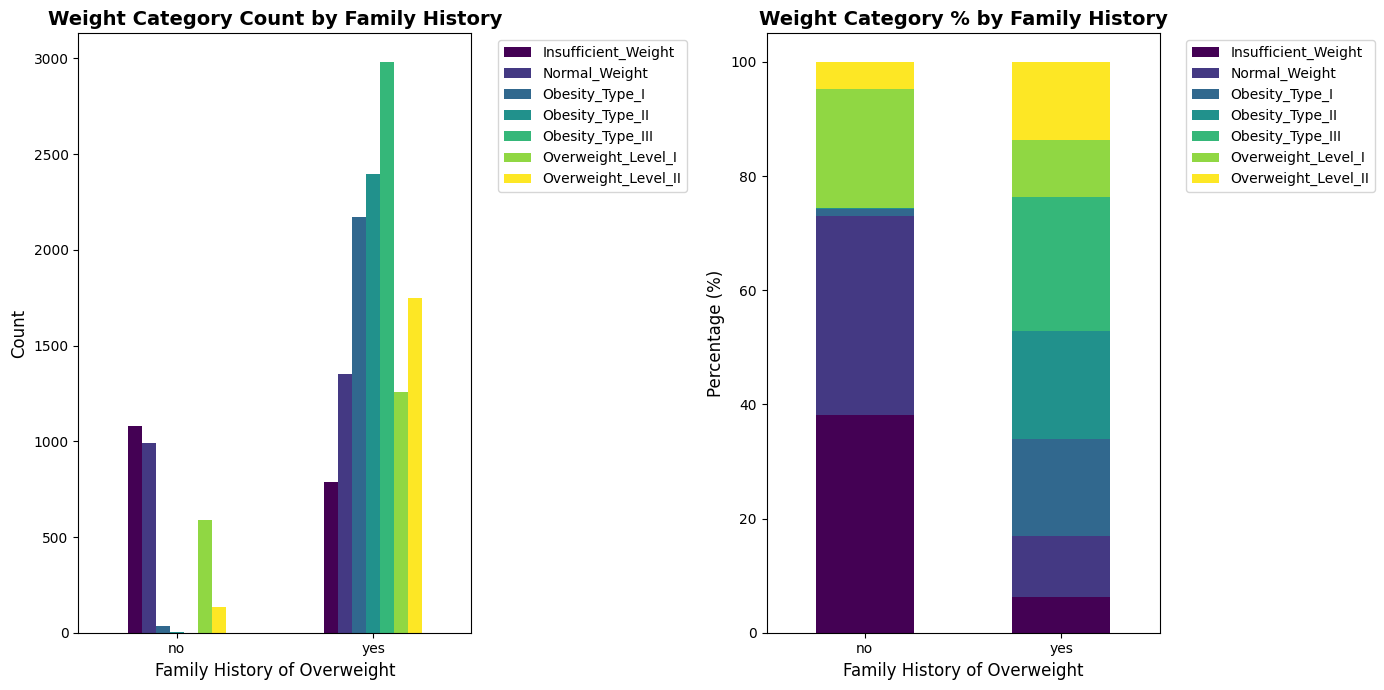

Cross-tabulation of Family History vs Weight Category:
WeightCategory                  Insufficient_Weight  Normal_Weight  \
family_history_with_overweight                                       
no                                             1081            992   
yes                                             789           1353   

WeightCategory                  Obesity_Type_I  Obesity_Type_II  \
family_history_with_overweight                                    
no                                          34                5   
yes                                       2173             2398   

WeightCategory                  Obesity_Type_III  Overweight_Level_I  \
family_history_with_overweight                                         
no                                             1                 589   
yes                                         2982                1255   

WeightCategory                  Overweight_Level_II  
family_history_with_overweight                      

In [14]:
plt.figure(figsize=(14,7))

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

family_history_count = pd.crosstab(df_train['family_history_with_overweight'],
                                   df_train['WeightCategory'])
family_history_count.plot(kind='bar', ax=ax1, colormap='viridis')
ax1.set_title('Weight Category Count by Family History', fontsize=14, fontweight='bold')
ax1.set_xlabel('Family History of Overweight', fontsize=12) 
ax1.set_ylabel('Count', fontsize=12) 
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

family_history_percentage = pd.crosstab(df_train['family_history_with_overweight'],
                                        df_train['WeightCategory'],
                                        normalize='index') * 100
family_history_percentage.plot(kind='bar', stacked=True, ax=ax2, colormap='viridis')
ax2.set_title('Weight Category % by Family History', fontsize=14, fontweight='bold')
ax2.set_xlabel('Family History of Overweight', fontsize=12) 
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("Cross-tabulation of Family History vs Weight Category:")
print(family_history_count)
print("\nPercentage distribution:")
print(family_history_percentage)


### Dietary Habits Analysis
#### it will examine the
- Frequency of consumption of high-caloric food (FAVC)
- Vegetable consumption frequency (FCVC)
- Number of main meals (NCP)
- Food consumption between meals (CAEC)
- Water consumption (CH2O)
- Alcohol consumption (CALC)
- How these factors correlate with different weight categories



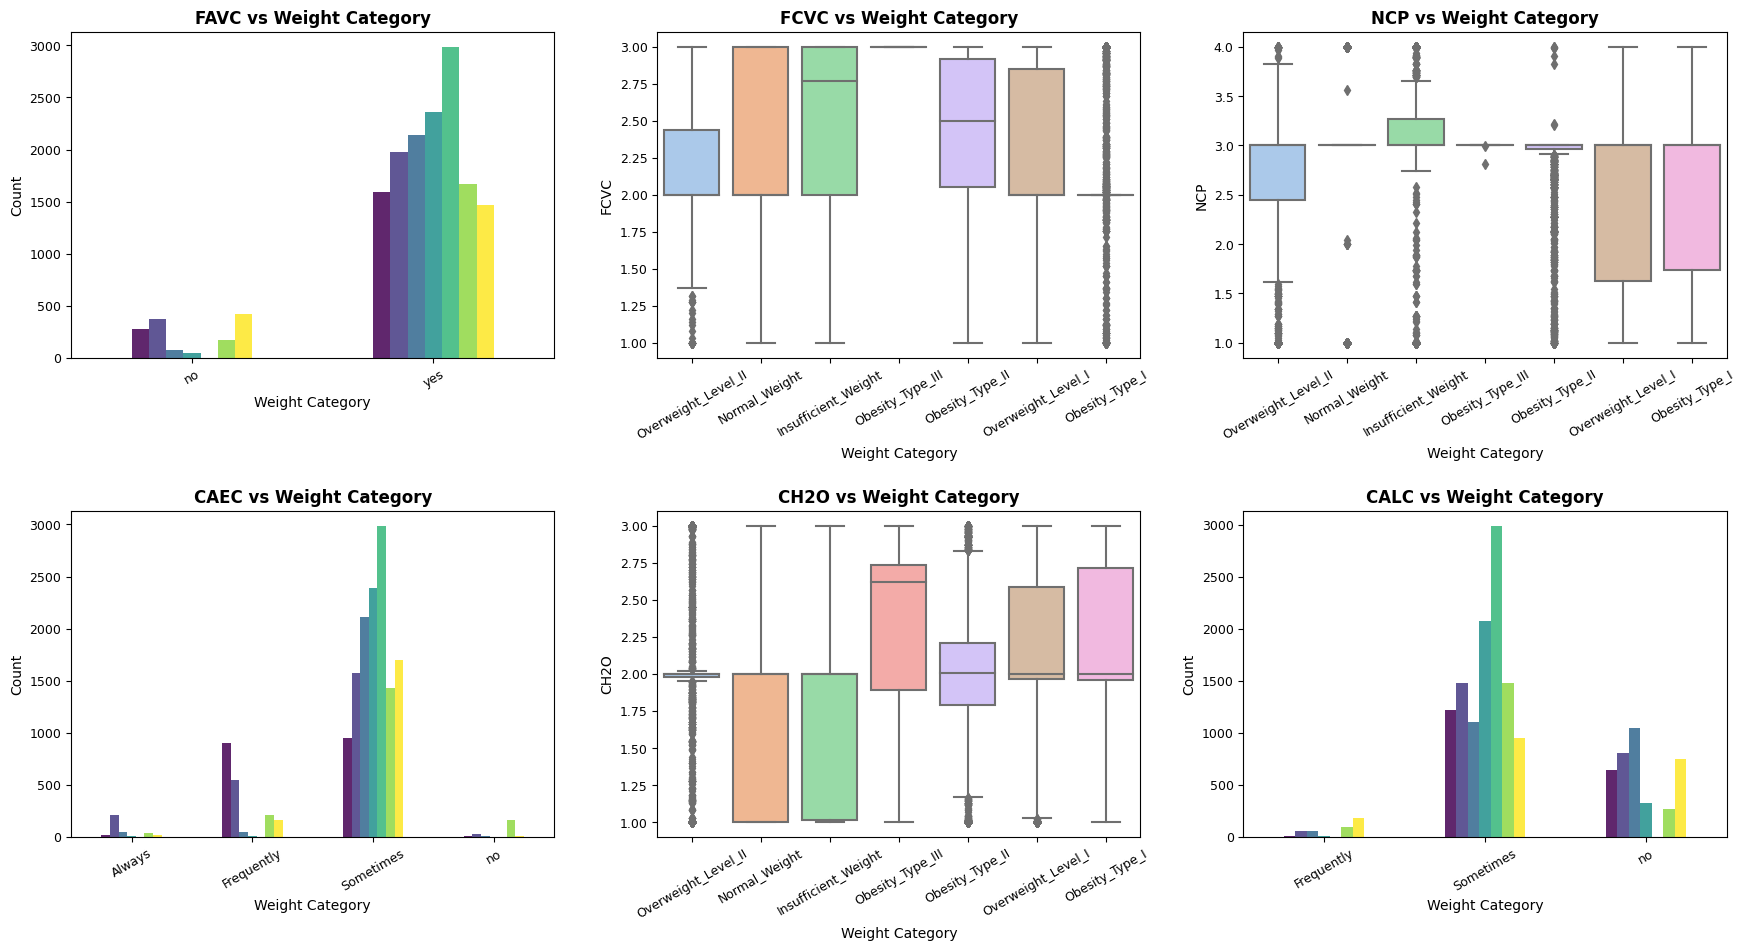

Summary of dietary habit features:
               FCVC           NCP          CH2O
count  15533.000000  15533.000000  15533.000000
mean       2.442917      2.760425      2.027626
std        0.530895      0.706463      0.607733
min        1.000000      1.000000      1.000000
25%        2.000000      3.000000      1.796257
50%        2.342220      3.000000      2.000000
75%        3.000000      3.000000      2.531456
max        3.000000      4.000000      3.000000


In [15]:
dietary_cols = ['FAVC', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'CALC']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(dietary_cols):
    if df_train[col].dtype == 'object' or df_train[col].nunique() < 10:
        pd.crosstab(df_train[col], df_train['WeightCategory']).plot(
            kind='bar', ax=axes[i], colormap='viridis', alpha=0.85, legend=False
        )
        axes[i].set_ylabel("Count")
    else:
        sns.boxplot(data=df_train, x='WeightCategory', y=col, ax=axes[i], palette='pastel')
        axes[i].set_ylabel(col)

    axes[i].set_title(f"{col} vs Weight Category", fontweight='bold', fontsize=12)
    axes[i].set_xlabel("Weight Category", fontsize=10)
    
    axes[i].tick_params(axis='x', rotation=30, labelsize=9)
    axes[i].tick_params(axis='y', labelsize=9)

plt.tight_layout(pad=2.5, w_pad=2, h_pad=2)
plt.show()

print("Summary of dietary habit features:")
print(df_train[dietary_cols].describe())


### Physical Activity Analysis
#### It will reveals
- Physical activity frequency (FAF) patterns
- Time using technology devices (TUE) - sedentary behavior
- Calorie consumption monitoring (SCC) habits
- Smoking status (SMOKE) distribution
- How lifestyle factors contribute to weight categories

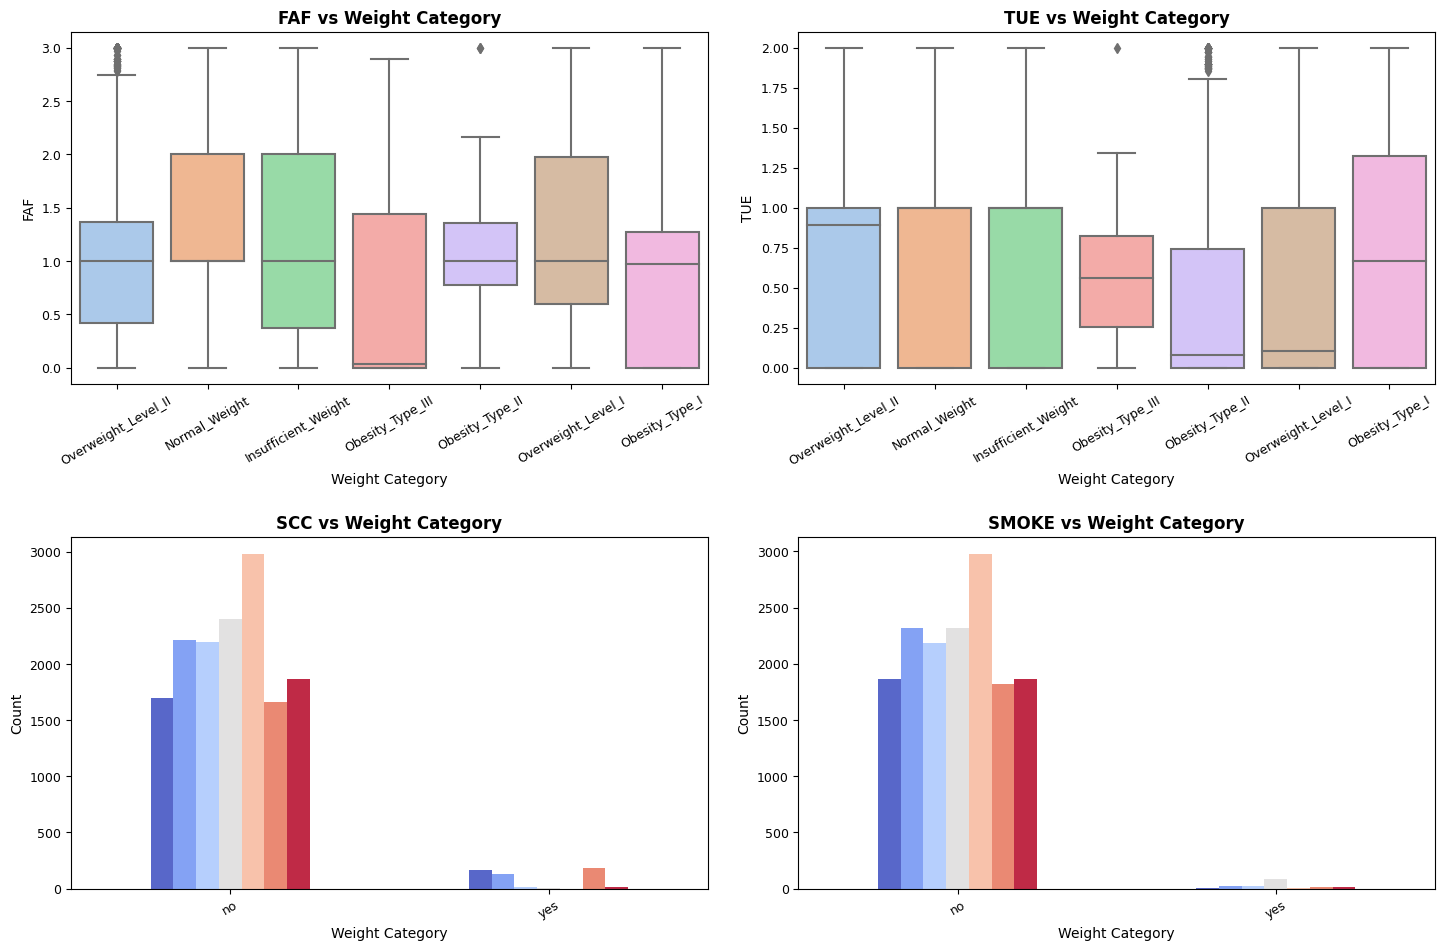

Average physical activity by weight category:
                      FAF   TUE
WeightCategory                 
Insufficient_Weight  1.20  0.80
Normal_Weight        1.18  0.63
Obesity_Type_I       0.90  0.73
Obesity_Type_II      1.04  0.41
Obesity_Type_III     0.55  0.55
Overweight_Level_I   1.12  0.54
Overweight_Level_II  1.04  0.69


In [16]:
activity_cols = ['FAF', 'TUE', 'SCC', 'SMOKE']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(activity_cols):
    if col in ['SCC', 'SMOKE']:
        pd.crosstab(df_train[col], df_train['WeightCategory']).plot(
            kind='bar', ax=axes[i], colormap='coolwarm', alpha=0.85, legend=False
        )
        axes[i].set_ylabel("Count")
    else:
        sns.boxplot(data=df_train, x='WeightCategory', y=col, ax=axes[i], palette='pastel')
        axes[i].set_ylabel(col)

    axes[i].set_title(f"{col} vs Weight Category", fontweight='bold', fontsize=12)
    axes[i].set_xlabel("Weight Category", fontsize=10)
    axes[i].tick_params(axis='x', rotation=30, labelsize=9)
    axes[i].tick_params(axis='y', labelsize=9)

plt.tight_layout(pad=2.5, w_pad=2, h_pad=2)
plt.show()

print("Average physical activity by weight category:")
print(df_train.groupby('WeightCategory')[['FAF', 'TUE']].mean().round(2))

# Stage-3 : Model Buiding And Evaluation